Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [102]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

In [103]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [104]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [105]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [106]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [107]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [108]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             validation_split=0.2,
                                                             subset="validation",
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [109]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

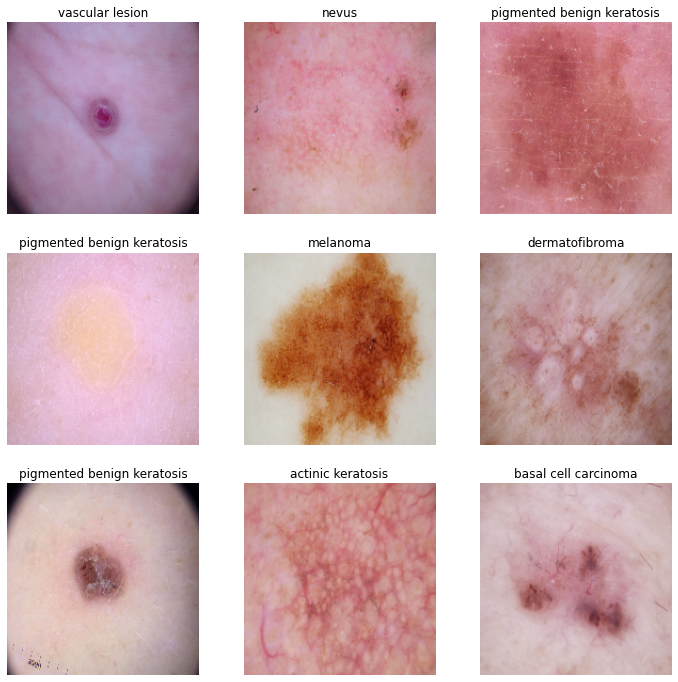

In [110]:
from re import I
import matplotlib.pyplot as plt
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12, 12))
for img, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[label[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [111]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [112]:
## Your code goes here
num_classes=len(class_names)

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(img_height, img_width, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (5, 5)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(512,kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [113]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

In [115]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 13s 93ms/step - loss: 15.4925 - accuracy: 0.2785 - val_loss: 12.8859 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 3s 62ms/step - loss: 11.8629 - accuracy: 0.3934 - val_loss: 13.4882 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 3s 62ms/step - loss: 11.3239 - accuracy: 0.4643 - val_loss: 14.7048 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 3s 62ms/step - loss: 11.0034 - accuracy: 0.5173 - val_loss: 13.2246 - val_accuracy: 0.2528
Epoch 5/20
56/56 [==============================] - 3s 62ms/step - loss: 10.6516 - accuracy: 0.5446 - val_loss: 13.6933 - val_accuracy: 0.2394
Epoch 6/20
56/56 [==============================] - 3s 62ms/step - loss: 10.4112 - accuracy: 0.5636 - val_loss: 11.9420 - val_accuracy: 0.2886
Epoch 7/20
56/56 [==============================] - 3s 62ms/step - loss: 10.1115 - accuracy: 0.5921 - val_loss: 12.1773 - val_accuracy: 0.272

In [116]:
# View the summary of all layers
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_12 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_70 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_94 (Activation)  (None, 180, 180, 32)      0         
                                                                 
 batch_normalization_64 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_71 (Conv2D)          (None, 178, 178, 32)      9248      
                                                                 
 activation_95 (Activation)  (None, 178, 178, 32)      0         
                                                     

### Visualizing training results

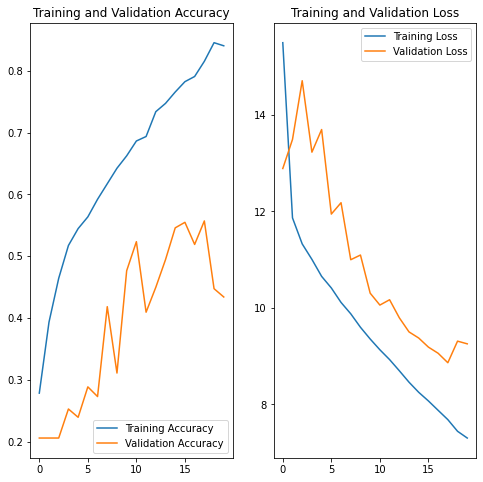

In [117]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### There is model overfitting as we can see the training accuracy goes above 85% whereas the validation accuracy is not more than 55%, it denotes that model is performing well but only on training data. Model is not performing in a generic manner irrespecttive of the dataset. The loss curve for each epochs also denotes as the number of epochs is more there is a reduction in training loss but there is a significant gap between validation loss and training loss.

In [118]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical",
                                                        input_shape=(img_height,img_width,3)),
                                      layers.RandomRotation(0.1),
                                      ])

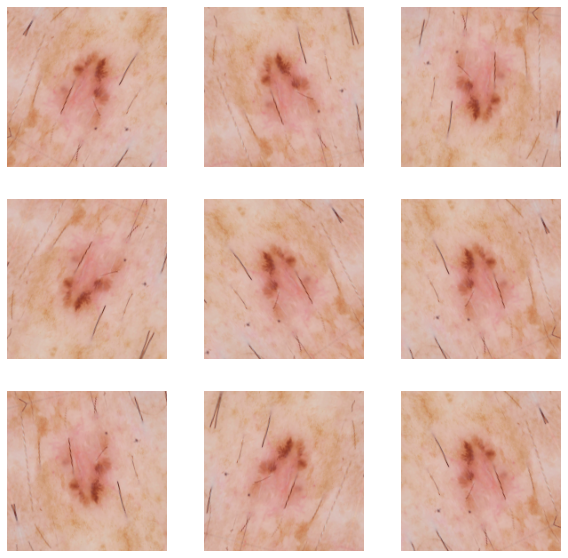

In [119]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [120]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential()
model.add(data_augmentation)
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(img_height, img_width, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (5, 5)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(512,kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

### Compiling the model

In [121]:
## Your code goes here
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training the model

In [122]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 67ms/step - loss: 15.3642 - accuracy: 0.2946 - val_loss: 13.0014 - val_accuracy: 0.1521
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 11.7803 - accuracy: 0.3906 - val_loss: 13.1393 - val_accuracy: 0.1946
Epoch 3/20
56/56 [==============================] - 4s 64ms/step - loss: 11.3845 - accuracy: 0.4375 - val_loss: 13.1317 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 11.1037 - accuracy: 0.4503 - val_loss: 14.4149 - val_accuracy: 0.2662
Epoch 5/20
56/56 [==============================] - 4s 64ms/step - loss: 10.8296 - accuracy: 0.4827 - val_loss: 13.5064 - val_accuracy: 0.2416
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 10.6030 - accuracy: 0.4972 - val_loss: 12.5928 - val_accuracy: 0.2573
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 10.3973 - accuracy: 0.5039 - val_loss: 11.8579 - val_accuracy: 0.3199

### Visualizing the results

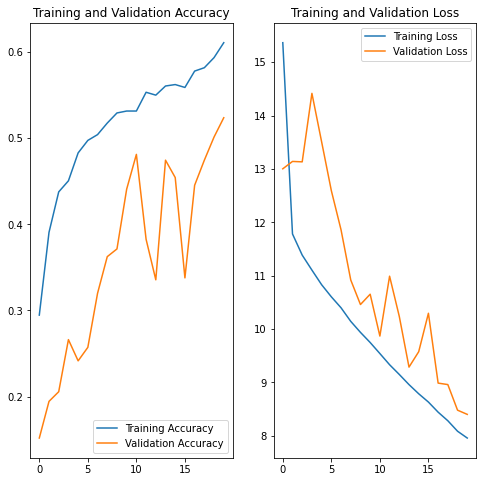

In [123]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

***Observation:*** Model overfit has reduced as we can see the training accuracy and validation accuracy is almost similar for higher epochs and also the validation loss is almost similar to training loss for higher epochs. Data augementation has some improvement as compared to previous model.

Although, the model accuracy has gone down as compared to previous model and it maybe because of reason such as class imbalance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [124]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train,'*','*.jpg'))]
label_list=[(lambda x: x.split('/')[-2])(x) for x in path_list]
df_list= list(zip(path_list, label_list))
df=  pd.DataFrame(df_list,columns=['Path','Label'])
print("count-wise")
print(df['Label'].value_counts())
print("\npercentage-wise")
print(round(df['Label'].value_counts()/len(df),2))

count-wise
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

percentage-wise
pigmented benign keratosis    0.21
melanoma                      0.20
basal cell carcinoma          0.17
nevus                         0.16
squamous cell carcinoma       0.08
vascular lesion               0.06
actinic keratosis             0.05
dermatofibroma                0.04
seborrheic keratosis          0.03
Name: Label, dtype: float64


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
***seborrheic keratosis***
#### - Which classes dominate the data in terms proportionate number of samples?
***pigmented benign keratosis***

***melanoma***

***basal cell carcinoma***

***nevus***

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [125]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [126]:
path_to_training_dataset="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+'/'+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F611EBB7B50>: 100%|██████████| 500/500 [00:09<00:00, 53.55 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6055CEAF10>: 100%|██████████| 500/500 [00:09<00:00, 50.84 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F605833E450>: 100%|██████████| 500/500 [00:10<00:00, 47.64 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F605826AAD0>: 100%|██████████| 500/500 [00:51<00:00,  9.64 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F611E743B10>: 100%|██████████| 500/500 [00:39<00:00, 12.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F605ABC3AD0>: 100%|██████████| 500/500 [00:08<00:00, 56.31 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F6058345910>: 100%|██████████| 500/500 [00:20<00:00, 24.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F611E543ED0>: 100%|██████████| 500/500 [00:10<00:00, 48.72 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F60586FC190>: 100%|██████████| 500/500 [00:09<00:00, 54.23 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [127]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [128]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032199.jpg_2b579f7d-2eb3-4420-a5c7-bd774ab068de.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033456.jpg_762f333a-08e1-4d77-b233-4888b52431fe.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_edb25379-92ce-4fb1-a08d-974029c57460.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030344.jpg_7c1b1bb3-473c-4f7c-85a0-d435b7491c26.jpg',
 '/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic

In [129]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [130]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [131]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [132]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [133]:
round(new_df['Label'].value_counts()/len(new_df),2)

pigmented benign keratosis    0.14
melanoma                      0.14
basal cell carcinoma          0.13
nevus                         0.13
squamous cell carcinoma       0.10
vascular lesion               0.09
actinic keratosis             0.09
dermatofibroma                0.09
seborrheic keratosis          0.09
Name: Label, dtype: float64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [139]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [140]:
data_dir_train="/content/gdrive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [141]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [142]:
## your code goes here
num_classes=len(class_names)

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(32, (3, 3), padding='same',input_shape=(img_height,img_width,3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512,kernel_regularizer=l2(0.01)))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [144]:
## your code goes here
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [145]:
epochs = 30
## Your code goes here, use 30 epochs.
# your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 22s 116ms/step - loss: 12.3995 - accuracy: 0.3420 - val_loss: 15.2242 - val_accuracy: 0.1054
Epoch 2/30
169/169 [==============================] - 20s 114ms/step - loss: 10.7936 - accuracy: 0.4188 - val_loss: 12.8667 - val_accuracy: 0.1908
Epoch 3/30
169/169 [==============================] - 20s 115ms/step - loss: 10.1150 - accuracy: 0.4546 - val_loss: 10.7863 - val_accuracy: 0.3653
Epoch 4/30
169/169 [==============================] - 20s 117ms/step - loss: 9.5053 - accuracy: 0.4792 - val_loss: 9.7953 - val_accuracy: 0.4016
Epoch 5/30
169/169 [==============================] - 20s 116ms/step - loss: 8.9460 - accuracy: 0.4939 - val_loss: 11.6240 - val_accuracy: 0.2539
Epoch 6/30
169/169 [==============================] - 20s 113ms/step - loss: 8.4373 - accuracy: 0.5083 - val_loss: 8.8003 - val_accuracy: 0.4484
Epoch 7/30
169/169 [==============================] - 20s 114ms/step - loss: 7.9475 - accuracy: 0.5195 - val_loss: 7.9067 -

In [146]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_15 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 sequential_17 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 conv2d_88 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 activation_118 (Activation)  (None, 180, 180, 32)     0         
                                                                 
 batch_normalization_82 (Bat  (None, 180, 180, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_89 (Conv2D)          (None, 178, 178, 32)      9248      
                                                     

#### **Todo:**  Visualize the model results

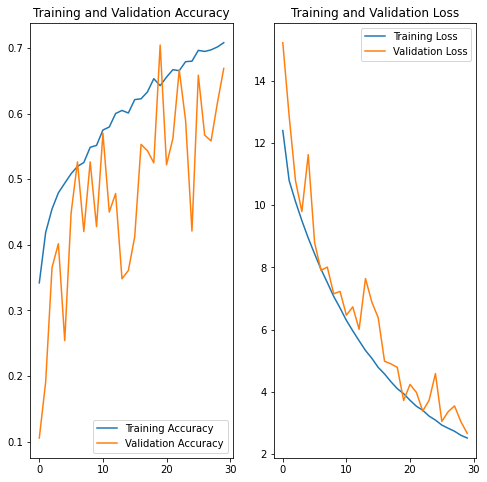

In [147]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



*Yes ! Class rebalance by adding extra images helped to improve accuracy on both training and validation dataset.
Class imbalance issue forces the model to learn from the class present in majority and it will wrongly classify or categorize minority classes which will lead to poor accuracy. 
***From the above graph, it can be observed that in the last few epochs, validation accuracy is almost similar to training accuracy and validation loss is almost similar to training loss***.*